In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = np.load('mnist.npz')
%matplotlib inline

# Data Preparation 

#### reading data and preparing the test, train and validation sets

In [130]:
data = np.load('mnist.npz')
X_train = data['x_train'][:48000].reshape(48000, 784)
y_train = data["y_train"][:48000]
X_valid = data['x_train'][48000:].reshape(12000, 784)
y_valid = data["y_train"][48000:]

X_test = data['x_test'].reshape(10000, 784)
y_test = data['y_test']

In [132]:
class MLP:  
    def __init__(self, init_method, input_size = 784, hidden_size = 512, output_size = 10, 
                 hidden_dims=(512,512), n_hidden=2, mode='train', datapath=None, model_path=None):
        """
        Initiate the Netweork in three required approach"""
        if (init_method == "normal"):
            
            W1 = np.random.normal(0, 1, (hidden_dims[0], input_size))
            b1 = np.zeros(hidden_size)
            W2 = np.random.normal(0, 1, (hidden_dims[1], hidden_dims[0]))
            b2 = np.zeros(hidden_size)
            W3 = np.random.normal(0, 1, (output_size, hidden_dims[1]))
            b3 = np.zeros(output_size)
            
        elif(init_method == "uniform"):
                       
            d0_Glorat = np.sqrt(6 / (input_size + hidden_dims[0]))
            W1 = np.random.uniform(-d0_Glorat, d0_Glorat, size=(hidden_dims[0], input_size))
            b1 = np.zeros(hidden_size)
            d1_Glorat = np.sqrt(6 / (hidden_size + hidden_size))
            W2 = np.random.uniform(-d1_Glorat, d1_Glorat, size=(hidden_dims[1], hidden_dims[0]))
            b2 = np.zeros(hidden_size)
            d2_Glorat = np.sqrt(6 / (output_size + hidden_size))
            W3 = np.random.uniform(-d2_Glorat, d2_Glorat, size=(output_size, hidden_dims[1]))
            b3 = np.zeros(output_size)
        
        elif(init_method == "zeros"):
            
            W1 = np.zeros((hidden_dims[0], input_size))
            b1 = np.zeros(hidden_size)
            W2 = np.zeros((hidden_dims[1], hidden_dims[0]))
            b2 = np.zeros(hidden_size)
            W3 = np.zeros((output_size, hidden_dims[1]))
            b3 = np.zeros(output_size)       
        
        self.Params = {'W1':W1, 'b1':b1,
                       'W2':W2, 'b2':b2,
                       'W3':W3, 'b3':b3}
          
    def forward(self, x):
        
        N = x.shape[0]
        h1, h1_cache = self.fc_forward(x, self.Params['W1'], self.Params['b1'])
        a1, a1_cache = self.relu_forward(h1)
        h2, h2_cache = self.fc_forward(a1, self.Params['W2'], self.Params['b2'])
        a2, a2_cache = self.relu_forward(h2)
        scores, scores_cache = self.fc_forward(a2, self.Params['W3'], self.Params['b3'])
        preds = np.argmax(scores, axis=1)
        self.cache = (N, h1_cache, a1_cache, h2_cache, a2_cache, scores_cache)
        return preds, scores
    
    def backward(self, dsoftmax, weight_decay=0):
        
        (N, h1_cache, a1_cache, h2_cache, a2_cache, scores_cache) = self.cache
        da2, dW3, db3= self.fc_backward(dsoftmax, scores_cache)
        dh2 = self.relu_backward(da2, a2_cache)
        da1, dW2, db2= self.fc_backward(dh2, h2_cache)
        dh1 = self.relu_backward(da1, a1_cache)
        
        _, dW1, db1= self.fc_backward(dh1, h1_cache)
        
        dW3 /= N
        dW2 /= N
        dW1 /= N
        db3 /= N
        db2 /= N
        db1 /= N
        
        dW3 += weight_decay * self.Params['W3']
        dW2 += weight_decay * self.Params['W2']
        dW1 += weight_decay * self.Params['W1']
        
        grads = {'W1':dW1, 'b1':db1,
                 'W2':dW2, 'b2':db2,
                 'W3':dW3, 'b3':db3}
        return grads
    
    def fc_forward(self, x, w, b):
        
        out = np.dot(x, w.T) + b
        cache = (x, w, b, out)
        return out, cache
    
    def fc_backward(self, dupstream, cache):
        
        (x, w, b, out) = cache
        dx = np.dot(dupstream, w)
        dw = np.dot(dupstream.T, x)
        db = dupstream.sum(axis=0)
        return dx, dw, db
    
    def relu_forward(self, x):        
        return np.maximum(0, x), x
    
    def relu_backward(self, dupstream, cache):
        
        return ((cache > 0) * dupstream)  
    
    def softmax_loss(self, x, y):
      
        shifted_logits = x - np.max(x, axis=1, keepdims=True)
        Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
        log_probs = shifted_logits - np.log(Z)
        probs = np.exp(log_probs)
        N = x.shape[0]
        loss = -np.sum(log_probs[np.arange(N), y]) / N
        dx = probs.copy()
        dx[np.arange(N), y] -= 1
        dx /= N
        return loss, dx
    
    def train(self, data, target, mb_size=100, learning_rate=1e-1, weight_decay=0.):
        
        for i in range(data.shape[0] // mb_size):
            xi = data[i*mb_size:(i+1)*mb_size]
            yi = target[i*mb_size:(i+1)*mb_size]
            preds, scores = self.forward(xi)
            softmax_loss, dsoftmax = self.softmax_loss(scores, yi)
            average_grads = self.backward(dsoftmax, weight_decay)
            for param, grad in average_grads.items():
                self.Params[param] -= learning_rate * grad
        return softmax_loss
    
    def test(self, x, y):
        preds, scores = self.forward(x)
        softmax_loss, dsoftmax = self.softmax_loss(scores, y)
        return softmax_loss, preds

In [133]:
def run(init_method, num_epochs = 3):
    mlp = MLP(init_method = init_method)
    train_accuracies, train_losses = [], []
    valid_accuracies, valid_losses = [], []
    test_accuracies, test_losses = [], []

    for e in range(num_epochs):
        loss = mlp.train(X_train, y_train, mb_size=100, learning_rate=1e-1)

        loss_train, pred_train = mlp.test(X_train, y_train)
        loss_valid, pred_valid = mlp.test(X_valid, y_valid)
        valid_losses.append(loss_valid)
        valid_accuracies.append((pred_valid == y_valid).mean())
        train_losses.append(loss_train)
        train_accuracies.append((pred_train == y_train).mean())

    plt.figure(figsize=(12, 4))
    axis = plt.subplot(1, 2, 1)
    axis.plot(range(1, len(train_losses)+1), train_losses, label='train')
    axis.plot(range(1, len(valid_losses)+1), valid_losses, label='valid')
    axis.legend()
    axis.set_ylabel('Loss')
    axis.set_xlabel('Epochs')
    axis = plt.subplot(1, 2, 2)
    axis.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train')
    axis.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid')
    axis.legend()
    axis.set_ylabel('Accuracy')
    axis.set_xlabel('Epochs')


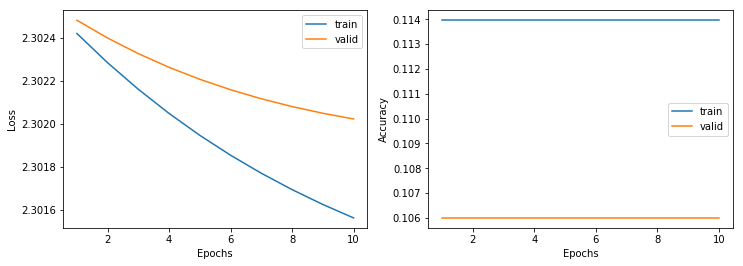

In [134]:
run(init_method = "normal", num_epochs=10)

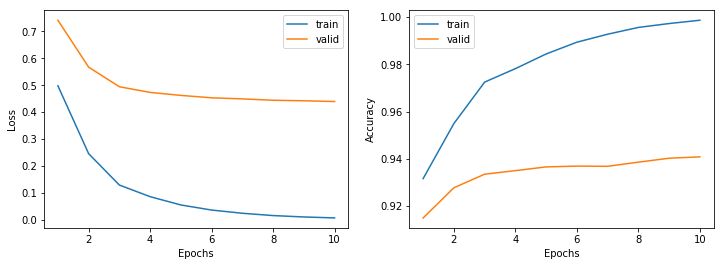

In [106]:
run(init_method = "uniform", num_epochs=10)

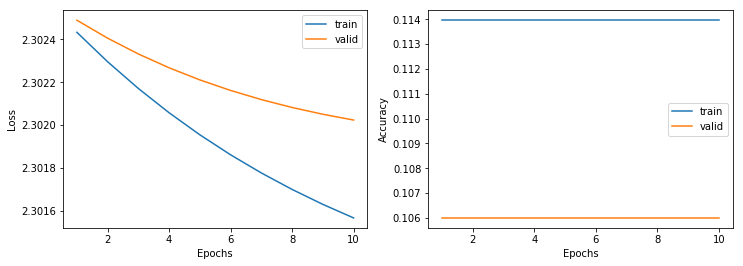

In [127]:
run(init_method = "zeros", num_epochs=10)